In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# zero-based (start, end) pairs, end is exclusive
colspecs = [
    (74, 76),    # MAGER       Mother’s age in single years (pos 75–76)
    # (78, 79),    # MAGER9      Mother’s age recode 9 (pos 79)
    (83, 84),    # MBSTATE_REC Mother’s nativity recode (pos 84)
    (170,172),   # PRIORLIVE   Prior live births now living (pos 171–172)
    (200,202),   # ILLB_R11    Interval since last live birth recode 11 (pos 201–202)
    (324,325),   # RF_INFTR    Infertility treatment used (pos 325)
    (325,326),   # RF_FEDRG    Fertility enhancing drugs (pos 326)
    (326,327),   # RF_ARTEC    Assisted reproductive tech flag (pos 327)
    (286,287),   # BMI_R       BMI recode (pos 287)
    (305,306),   # WTGAIN_REC  Weight gain recode (pos 306)
    (260,261),   # CIG0_R      Cigarettes before pregnancy recode (pos 261)
    (261,262),   # CIG1_R      Cigarettes 1st trimester recode (pos 262)
    (226,227),   # PRECARE5    Month prenatal care began recode (pos 227)
    (241,243),   # PREVIS_REC  Prenatal visits recode (pos 242–243)
    (250,251),   # WIC         WIC participation flag (pos 251)
    (317,318),   # RF_PPTERM   Prior preterm birth flag (pos 318)
    (312,313),   # RF_PDIAB    Pre-pregnancy diabetes flag (pos 313)
    (314,315),   # RF_PHYPE    Pre-pregnancy hypertension flag (pos 315)
    (453,454),   # DPLURAL     Plurality recode (pos 454) -- target
    (455,456),   # IMP_PLUR    Plurality imputed flag (pos 456)
]

column_names = [
    "mager", "mbstate_rec",
    "priorlive", "illb_r11",
    "rf_inftr", "rf_fedrg", "rf_artec",
    "bmi_r", "wtgain_rec",
    "cig0_r", "cig1_r",
    "precare5", "previs_rec", "wic",
    "rf_ppterm", "rf_pdiab", "rf_phype",
    "dplural", "imp_plur",
]
import pandas as pd

# Load data from fixed-width file
df = pd.read_fwf("data.txt",
                 colspecs=colspecs,
                 names=column_names,
                 na_values=["U", "9", "99", "999"])

In [5]:
df.head()

,mager,mbstate_rec,priorlive,illb_r11,rf_inftr,rf_fedrg,rf_artec,bmi_r,wtgain_rec,cig0_r,cig1_r,precare5,previs_rec,wic,rf_ppterm,rf_pdiab,rf_phype,dplural,imp_plur
0,37,1,1.0,4.0,N,X,X,2.0,2.0,0,0,1,7.0,N,N,N,N,1,NaN
1,29,2,1.0,8.0,N,X,X,4.0,3.0,0,0,1,5.0,Y,N,N,N,1,NaN
2,22,1,1.0,3.0,N,X,X,2.0,3.0,0,0,1,6.0,N,N,N,N,1,NaN
3,21,1,2.0,4.0,N,X,X,4.0,5.0,0,0,1,4.0,N,N,N,N,1,NaN
4,35,2,0.0,88.0,N,X,X,2.0,3.0,0,0,1,6.0,Y,N,N,N,1,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605081 entries, 0 to 3605080
Data columns (total 19 columns):
 #   Column       Dtype  
---  ------       -----  
 0   mager        int64  
 1   mbstate_rec  int64  
 2   priorlive    float64
 3   illb_r11     float64
 4   rf_inftr     object 
 5   rf_fedrg     object 
 6   rf_artec     object 
 7   bmi_r        float64
 8   wtgain_rec   float64
 9   cig0_r       int64  
 10  cig1_r       int64  
 11  precare5     int64  
 12  previs_rec   float64
 13  wic          object 
 14  rf_ppterm    object 
 15  rf_pdiab     object 
 16  rf_phype     object 
 17  dplural      int64  
 18  imp_plur     float64
dtypes: float64(6), int64(6), object(7)
memory usage: 522.6+ MB


In [9]:
df.describe()

,mager,mbstate_rec,priorlive,illb_r11,bmi_r,wtgain_rec,cig0_r,cig1_r,precare5,previs_rec,dplural,imp_plur
count,3.605081e+06,3.605081e+06,3.596438e+06,3.502052e+06,3.522423e+06,3.502109e+06,3.605081e+06,3.605081e+06,3.605081e+06,3.322720e+06,3.605081e+06,218.0
mean,2.958147e+01,1.240803e+00,1.114322e+00,3.838574e+01,3.102935e+00,3.229624e+00,1.044104e-01,8.088584e-02,1.401277e+00,6.554986e+00,1.032220e+00,1.0
std,5.818580e+00,4.329246e-01,1.309952e+00,4.077125e+01,1.247201e+00,1.255318e+00,5.809940e-01,5.181655e-01,8.328000e-01,2.058567e+00,1.811711e-01,0.0
min,1.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0
25%,2.500000e+01,1.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.0
50%,3.000000e+01,1.000000e+00,1.000000e+00,8.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,1.0
75%,3.400000e+01,1.000000e+00,2.000000e+00,8.800000e+01,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,8.000000e+00,1.000000e+00,1.0
max,5.000000e+01,3.000000e+00,2.000000e+01,8.800000e+01,6.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00,5.000000e+00,1.200000e+01,4.000000e+00,1.0


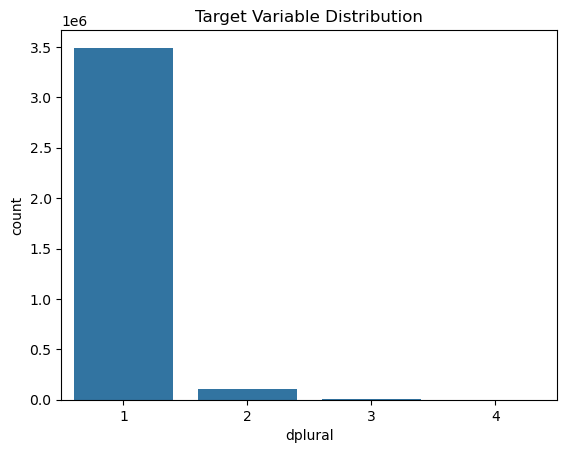

,proportion
dplural,
1,0.968559
2,0.030702
3,0.000697
4,0.000041


In [11]:
sns.countplot(x=df['dplural'])
plt.title("Target Variable Distribution")
plt.show()

# Numeric breakdown
df['dplural'].value_counts(normalize=True).to_frame(name='proportion')

In [13]:
# Drop duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1146820 entries, 0 to 3605079
Data columns (total 19 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   mager        1146820 non-null  int64  
 1   mbstate_rec  1146820 non-null  int64  
 2   priorlive    1139879 non-null  float64
 3   illb_r11     1075663 non-null  float64
 4   rf_inftr     1141922 non-null  object 
 5   rf_fedrg     1139902 non-null  object 
 6   rf_artec     1139902 non-null  object 
 7   bmi_r        1099556 non-null  float64
 8   wtgain_rec   1084943 non-null  float64
 9   cig0_r       1146820 non-null  int64  
 10  cig1_r       1146820 non-null  int64  
 11  precare5     1146820 non-null  int64  
 12  previs_rec   1059837 non-null  float64
 13  wic          1114902 non-null  object 
 14  rf_ppterm    1141922 non-null  object 
 15  rf_pdiab     1141922 non-null  object 
 16  rf_phype     1141922 non-null  object 
 17  dplural      1146820 non-null  int64  
 18  imp_plu

In [15]:
# Make the target variable binary
df['multiple_birth'] = df['dplural'].apply(lambda x: 1 if x > 1 else 0)
df = df.drop(columns=['dplural'])

In [17]:
# Convert IMP_PLUR to binary. 0 = not imputed, 1 = imputed
df['imp_plur'] = df['imp_plur'].fillna(0).astype(int)

print(df['imp_plur'].value_counts())

imp_plur
0    1146682
1        138
Name: count, dtype: int64


In [19]:
# missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing_summary)


Missing Values:
previs_rec        86983
illb_r11          71157
wtgain_rec        61877
bmi_r             47264
wic               31918
priorlive          6941
rf_fedrg           6918
rf_artec           6918
rf_ppterm          4898
rf_inftr           4898
rf_phype           4898
rf_pdiab           4898
mager                 0
imp_plur              0
cig0_r                0
precare5              0
cig1_r                0
mbstate_rec           0
multiple_birth        0
dtype: int64


In [21]:
# Filling in missing values

# Numeric columns: use median
numeric_cols = ['previs_rec', 'illb_r11', 'wtgain_rec', 'bmi_r', 'priorlive']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical columns: use mode
cat_cols = ['wic', 'rf_fedrg', 'rf_artec', 'rf_inftr', 'rf_ppterm', 'rf_pdiab', 'rf_phype']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [23]:
# missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing_summary)

Missing Values:
mager             0
cig1_r            0
imp_plur          0
rf_phype          0
rf_pdiab          0
rf_ppterm         0
wic               0
previs_rec        0
precare5          0
cig0_r            0
mbstate_rec       0
wtgain_rec        0
bmi_r             0
rf_artec          0
rf_fedrg          0
rf_inftr          0
illb_r11          0
priorlive         0
multiple_birth    0
dtype: int64


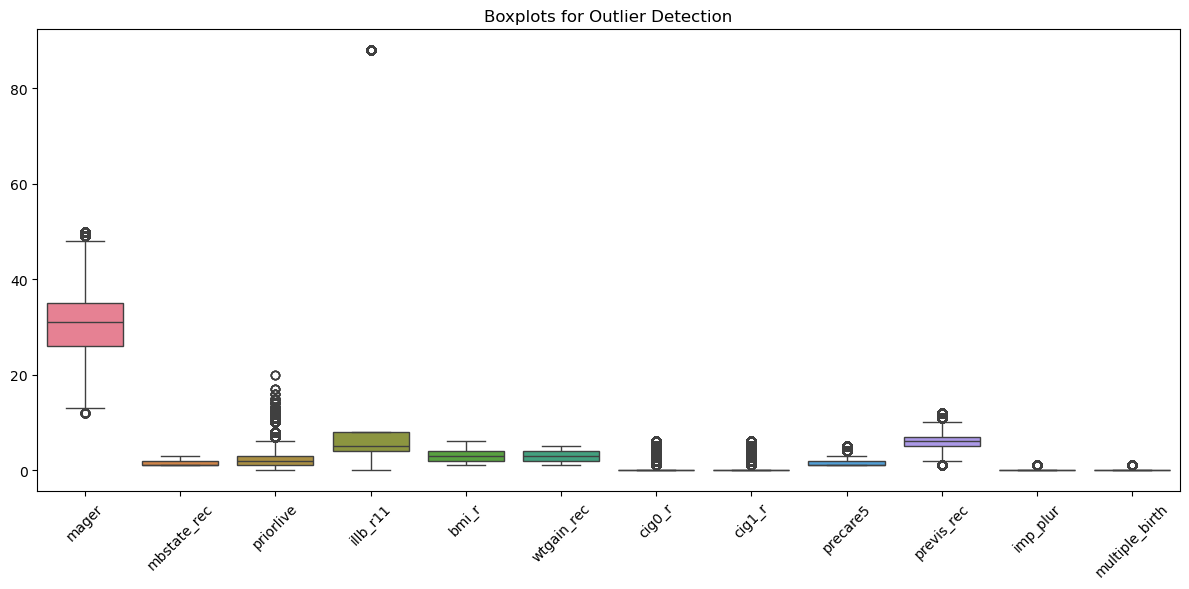

In [25]:
# Analizing outliers
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Cap outliers
def cap_outliers(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    return df

numeric_cols = df.select_dtypes(include='number').columns.tolist()
df = cap_outliers(df, numeric_cols)

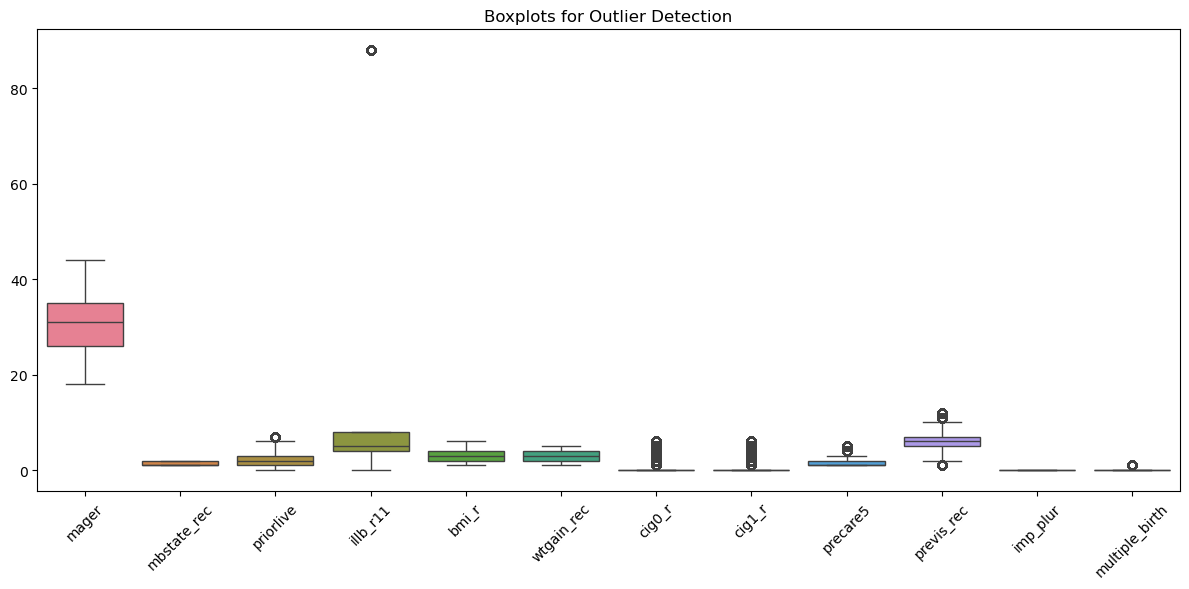

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots for Outlier Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# encoding

# Define binary/categorical columns with Y/N/U/X
binary_features = [
    'wic', 'rf_artec', 'rf_pdiab', 'rf_phype',
    'rf_ppterm', 'rf_inftr', 'rf_fedrg'
]

# Mapping: Y=1, N=0, U/X=0
binary_map = {'Y': 1, 'N': 0, 'U': 0, 'X': 0}

# Apply mapping to each feature column
for col in binary_features:
    df[col] = df[col].map(binary_map)

# One-hot encode 'mbstate_rec' (3 categories: 1, 2, 3)
df = pd.get_dummies(df, columns=['mbstate_rec'], prefix='mbstate', drop_first=True)

# Check that all remaining columns are numeric
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print("Non-numeric columns remaining:", non_numeric_cols)

Non-numeric columns remaining: ['mbstate_2']


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1146820 entries, 0 to 3605079
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   mager           1146820 non-null  int64  
 1   priorlive       1146820 non-null  float64
 2   illb_r11        1146820 non-null  float64
 3   rf_inftr        1146820 non-null  int64  
 4   rf_fedrg        1146820 non-null  int64  
 5   rf_artec        1146820 non-null  int64  
 6   bmi_r           1146820 non-null  float64
 7   wtgain_rec      1146820 non-null  float64
 8   cig0_r          1146820 non-null  int64  
 9   cig1_r          1146820 non-null  int64  
 10  precare5        1146820 non-null  int64  
 11  previs_rec      1146820 non-null  float64
 12  wic             1146820 non-null  int64  
 13  rf_ppterm       1146820 non-null  int64  
 14  rf_pdiab        1146820 non-null  int64  
 15  rf_phype        1146820 non-null  int64  
 16  imp_plur        1146820 non-null  int64  

In [35]:
# casting boolean variable to integer
df['mbstate_2'] = df['mbstate_2'].astype(int)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1146820 entries, 0 to 3605079
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   mager           1146820 non-null  int64  
 1   priorlive       1146820 non-null  float64
 2   illb_r11        1146820 non-null  float64
 3   rf_inftr        1146820 non-null  int64  
 4   rf_fedrg        1146820 non-null  int64  
 5   rf_artec        1146820 non-null  int64  
 6   bmi_r           1146820 non-null  float64
 7   wtgain_rec      1146820 non-null  float64
 8   cig0_r          1146820 non-null  int64  
 9   cig1_r          1146820 non-null  int64  
 10  precare5        1146820 non-null  int64  
 11  previs_rec      1146820 non-null  float64
 12  wic             1146820 non-null  int64  
 13  rf_ppterm       1146820 non-null  int64  
 14  rf_pdiab        1146820 non-null  int64  
 15  rf_phype        1146820 non-null  int64  
 16  imp_plur        1146820 non-null  int64  

In [39]:
# split data
from sklearn.model_selection import train_test_split

X = df.drop(columns=['multiple_birth'])
y = df['multiple_birth']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [41]:
# the target is extremely unbalanced so I applying SMOTE to the training data

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [47]:
# Use Logistic Regression as a baseline model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_transformed = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_resampled_scaled, y_train_resampled)

y_pred = model.predict(X_test_transformed)

# Evaluation 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.67      0.78    212627
           1       0.12      0.59      0.20     16737

    accuracy                           0.66    229364
   macro avg       0.54      0.63      0.49    229364
weighted avg       0.89      0.66      0.74    229364

[[141399  71228]
 [  6797   9940]]
